In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, current_date, log
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import pickle

In [120]:
spark = SparkSession.builder.appName('CarPricePrediction').getOrCreate()

In [121]:
data = spark.read.csv('/content/car data.csv', header=True, inferSchema=True)
data.show(5)

+--------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|Car_Name|Year|Selling_Price|Present_Price|Kms_Driven|Fuel_Type|Seller_Type|Transmission|Owner|
+--------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|    ritz|2014|         3.35|         5.59|     27000|   Petrol|     Dealer|      Manual|    0|
|     sx4|2013|         4.75|         9.54|     43000|   Diesel|     Dealer|      Manual|    0|
|    ciaz|2017|         7.25|         9.85|      6900|   Petrol|     Dealer|      Manual|    0|
| wagon r|2011|         2.85|         4.15|      5200|   Petrol|     Dealer|      Manual|    0|
|   swift|2014|          4.6|         6.87|     42450|   Diesel|     Dealer|      Manual|    0|
+--------+----+-------------+-------------+----------+---------+-----------+------------+-----+
only showing top 5 rows



In [122]:
data.printSchema()

root
 |-- Car_Name: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Selling_Price: double (nullable = true)
 |-- Present_Price: double (nullable = true)
 |-- Kms_Driven: integer (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- Seller_Type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Owner: integer (nullable = true)



In [123]:
data.describe().show()

+-------+--------+------------------+-----------------+-----------------+-----------------+---------+-----------+------------+-------------------+
|summary|Car_Name|              Year|    Selling_Price|    Present_Price|       Kms_Driven|Fuel_Type|Seller_Type|Transmission|              Owner|
+-------+--------+------------------+-----------------+-----------------+-----------------+---------+-----------+------------+-------------------+
|  count|     301|               301|              301|              301|              301|      301|        301|         301|                301|
|   mean|   800.0|2013.6279069767443|4.661295681063127|7.628471760797344|36947.20598006644|     NULL|       NULL|        NULL|0.04318936877076412|
| stddev|    NULL|2.8915541273367253|5.082811556177805|8.644115402015789|38886.88388206789|     NULL|       NULL|        NULL| 0.2479148926949198|
|    min|     800|              2003|              0.1|             0.32|              500|      CNG|     Dealer|   Au

# EDA

In [124]:
unique_seller_types = data.select("Seller_Type").distinct().collect()
[row["Seller_Type"] for row in unique_seller_types]

['Individual', 'Dealer']

In [125]:
unique_transmission = data.select("Transmission").distinct().collect()
[row["Transmission"] for row in unique_transmission]

['Automatic', 'Manual']

In [126]:
unique_owner = data.select("Owner").distinct().collect()
[row["Owner"] for row in unique_owner]

[1, 3, 0]

In [127]:
unique_fuel_type = data.select("Fuel_Type").distinct().collect()
[row["Fuel_Type"] for row in unique_fuel_type]

['Diesel', 'CNG', 'Petrol']

In [128]:
pandas_data = data.toPandas()

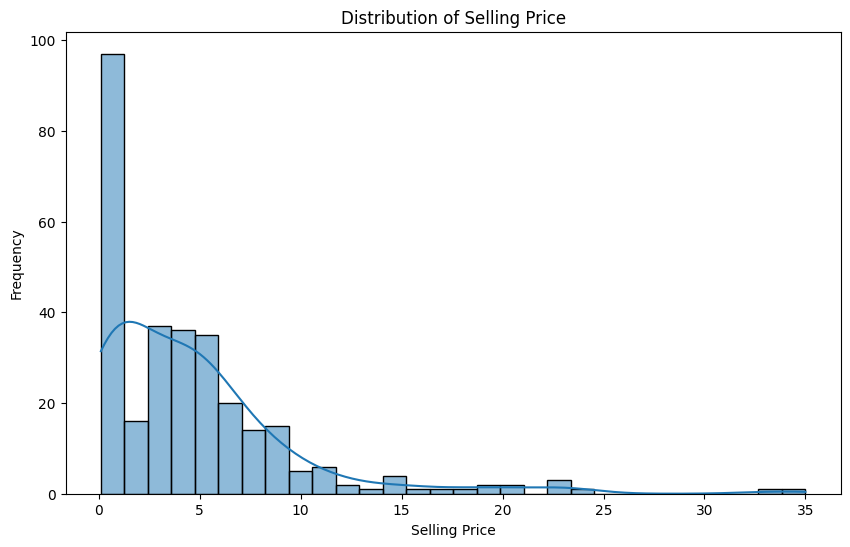

In [129]:
plt.figure(figsize=(10, 6))
sns.histplot(pandas_data['Selling_Price'], kde=True, bins=30)
plt.title('Distribution of Selling Price')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()

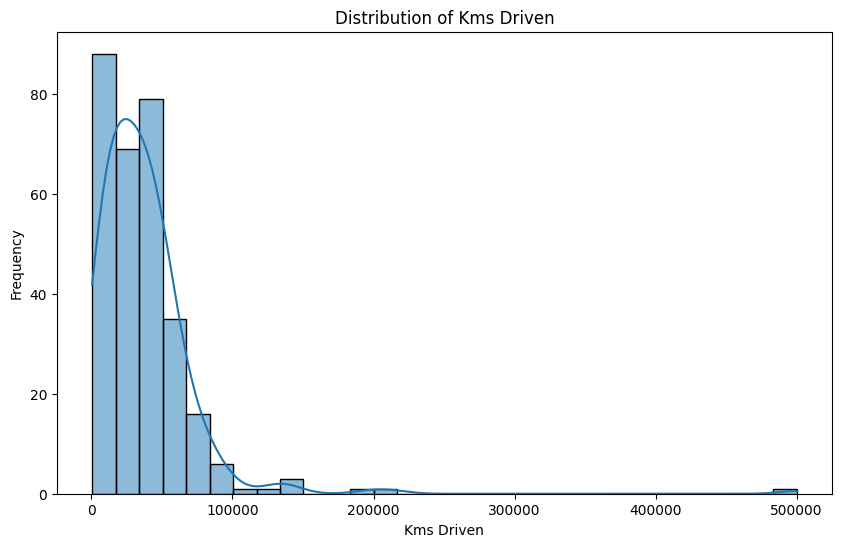

In [130]:
plt.figure(figsize=(10, 6))
sns.histplot(pandas_data['Kms_Driven'], kde=True, bins=30)
plt.title('Distribution of Kms Driven')
plt.xlabel('Kms Driven')
plt.ylabel('Frequency')
plt.show()

# Feature Engineering

In [131]:
data = data.withColumn('current_year', year(current_date()))

In [132]:
data = data.withColumn('No_of_years', col('current_year') - col('Year'))

In [133]:
data = data.drop('Year', 'current_year')

In [134]:
indexer = StringIndexer(inputCols=['Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
                        outputCols=['Fuel_Type_Idx', 'Seller_Type_Idx', 'Transmission_Idx', 'Owner_Idx'],
                        handleInvalid='skip')

In [135]:
encoder = OneHotEncoder(inputCols=['Fuel_Type_Idx', 'Seller_Type_Idx', 'Transmission_Idx', 'Owner_Idx'],
                        outputCols=['Fuel_Type_OneHot', 'Seller_Type_OneHot', 'Transmission_OneHot', 'Owner_OneHot'])

In [136]:
data = data.withColumn('Log_Price', log(col('Selling_Price')))

In [137]:
assembler = VectorAssembler(inputCols=['No_of_years', 'Present_Price', 'Kms_Driven',
                                       'Fuel_Type_OneHot', 'Seller_Type_OneHot',
                                       'Transmission_OneHot', 'Owner_OneHot', 'Log_Price'],
                            outputCol='features')

In [138]:
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

# Model Training

In [139]:
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='Log_Price')

In [140]:
pipeline = Pipeline(stages=[indexer, encoder, assembler, scaler, rf])

In [141]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

In [142]:
param_grid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [50, 100, 200])
              .addGrid(rf.maxDepth, [5, 10, 15])
              .addGrid(rf.minInstancesPerNode, [1, 5, 10])
              .addGrid(rf.maxBins, [32, 64])
              .build())

In [143]:
evaluator = RegressionEvaluator(labelCol='Log_Price', predictionCol='prediction', metricName='rmse')
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

In [144]:
cv_model = crossval.fit(train_data)

In [145]:
rf_model = cv_model.bestModel.stages[4]
feature_importances = rf_model.featureImportances

In [146]:
features = ['No_of_years', 'Present_Price', 'Kms_Driven', 'Fuel_Type_OneHot', 'Seller_Type_OneHot',
            'Transmission_OneHot', 'Owner_OneHot', 'Log_Price']
for feature, importance in zip(features, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: No_of_years, Importance: 0.02934947292442731
Feature: Present_Price, Importance: 0.283451529669967
Feature: Kms_Driven, Importance: 0.018295697299723135
Feature: Fuel_Type_OneHot, Importance: 0.03563160738645692
Feature: Seller_Type_OneHot, Importance: 0.035888699484389476
Feature: Transmission_OneHot, Importance: 0.1718606055393542
Feature: Owner_OneHot, Importance: 0.012033994531026588
Feature: Log_Price, Importance: 0.00174094675058784


# Model Evaluation

In [147]:
predictions = cv_model.transform(test_data)

In [148]:
rmse_evaluator = RegressionEvaluator(labelCol="Log_Price", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="Log_Price", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="Log_Price", predictionCol="prediction", metricName="r2")

In [149]:
rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)
r2 = r2_evaluator.evaluate(predictions)

In [150]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Root Mean Squared Error (RMSE): 0.09485289804033127
Mean Absolute Error (MAE): 0.062128754385543786
R-squared (R2): 0.9946722102341798


In [151]:
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.09485289804033127


In [152]:
predictions.select('Selling_Price', 'prediction').show(5)

+-------------+-------------------+
|Selling_Price|         prediction|
+-------------+-------------------+
|         0.17|-1.7943046760260402|
|         0.18| -1.272714662539506|
|         0.25|-1.4261195501769175|
|         0.52|-0.8192739304654136|
|         0.45|-0.7366702099078541|
+-------------+-------------------+
only showing top 5 rows



In [154]:
spark.stop()